In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import os

In [19]:
## use the pickle dict instead of reading this excel file 
## to use same preprocessing steps as in clustering 
# df = pd.read_excel('./data/final_data/ratios_plbs_agg_100_autosect.xlsx')

In [22]:
with open('./data/final_data/company_data_dict.pkl','rb') as f:
    cmpy_dict = pickle.load(f)

In [23]:
len(cmpy_dict)

96

In [24]:
#reading the cluster.csv
sheet_name = input('enter the number of clusters')+'clusters'
cluster = pd.read_excel('./data/15_18.xlsx',sheet_name=sheet_name)

In [25]:
cluster_dict  = dict((i,cluster[i].dropna().tolist()) for i in cluster.columns)

In [6]:
## no need for this

# non_features = ['Co_Code','CO_NAME','Year End']

# features = df.columns[3:]

# NUM_FEATURES = df.shape[1] - len(non_features)

In [26]:
NUM_YEARS = 19

Make all the company matrices into the same shape

In [27]:
NUM_FEATURES = 59

In [28]:
# 2
def df_to_dict(cmpy_dict,NUM_YEARS=NUM_YEARS,NUM_FEATURES = NUM_FEATURES):
    keys = list(cmpy_dict.keys())
#     dict_ = dict( (i,df[df.CO_NAME==i].sort_values('Year End') ) for i in df.CO_NAME.unique())
#     keys = dict_.keys()
    values = list(cmpy_dict.values())
#     values = [x.drop(columns = non_features) for x in values]
#     values = [x.values for x in values]
    values =  [ np.vstack([np.zeros(shape = (NUM_YEARS-x.shape[0],NUM_FEATURES )), x ]) for x in values ]
    return dict((i,j) for i,j in zip(keys,values))



In [29]:
df_dict = df_to_dict(cmpy_dict)

calculate dict of cluster values based on the median from the above values

In [30]:
all_vals = list(cluster_dict.values())
all_vals = [i for j in all_vals for i in j]

In [31]:
assert len(all_vals)==sum(i in df_dict.keys() for i in all_vals)

In [32]:
def cluster_mat(df_dict=df_dict , cluster_dict= cluster_dict):
    dict_ = dict( (i , [df_dict[k] for k in j]) for i,j in cluster_dict.items() )
    dict_ = dict( (i , np.stack(j,axis=2)) for i,j in dict_.items())
    return dict_

In [33]:
cluster_med = cluster_mat()

In [34]:
def cluster_median(cluster_med):
    return dict((i,np.median(j,2)) for i,j in cluster_med.items())

In [35]:
cluster_med = cluster_median(cluster_med)

In [36]:
with open('./data/final_data/col_names_list.pkl','rb') as f:
    features = pickle.load(f)

In [37]:
cluster_med_df = dict((i , pd.DataFrame(j,columns=features)) for i,j in cluster_med.items())

In [38]:
with open('./data/final_data/cluster_med_df.pickle','wb') as f:
    pickle.dump(cluster_med_df,f)

#####

To Read the cluster Median values df read below code

In [39]:

with open('./data/final_data/cluster_med_df.pickle','rb') as f:
    cluster_med_df = pickle.load(f)

NameError: name 'df' is not defined

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [24]:
def scale_features(train_x,test_x):
    scaler = MinMaxScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    return train_x_scaled , test_x_scaled

In [188]:


def give_models():
    names = ['Random_Forest','Gradient_Boosting','Adaboost','Xgboost']
    regs = [ RandomForestRegressor() , GradientBoostingRegressor() , AdaBoostRegressor(),XGBRegressor()]
    return names,regs

def give_param_dict():
    d_ =  {'Random_Forest':{'n_estimators':[5,10,15,20,25] , 'max_depth':[2,3,4,5]}
           ,'Gradient_Boosting':{'learning_rate':[0.01,0.03,0.1,0.3,1,3],'n_estimators':[5,10,15,20],'max_depth':[2,3,4,5]}
           ,'Adaboost':{'n_estimators':[5,10,15,20],'learning_rate':[0.01,0.03,0.1,0.3,1,3]}
           ,'Xgboost':{'max_depth':[2,3,4,5],'learning_rate':[0.01,0.03,0.1,0.3,1,3],'n_estimators':[5,10,15,20,25]} }
    return d_
    
def give_scores(train_x_scaled,train_y,test_x_scaled,test_y):
    names,regs = give_names()
    scores = [local_mae(i,train_x_scaled,train_y,test_x_scaled,test_y) for i in regs]
    return names , scores

def local_fit_model(model,train_x,train_y):
    model.fit(train_x,train_y)
    return model

def local_predict(model,test_x):
    return model.predict(test_x)

def local_mae(model,train_x,train_y,test_x,test_y):
    model = local_fit_model(model,train_x,train_y)
    preds = local_predict(model,test_x)
    return mean_absolute_error(test_y,preds)

In [27]:
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV

In [37]:
feat_path = os.path.join(os.getcwd(),'feat_select_ind')
if not os.path.exists(feat_path):
    os.mkdir(feat_path)

In [121]:
param_path = os.path.join(os.getcwd(),'param_select_ind')
if not os.path.exists(param_path):
    os.mkdir(param_path)

In [222]:
param_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/param_select_ind'
feat_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/feat_select_ind'

In [131]:
from sklearn.metrics import make_scorer

In [234]:
class CustomModel:
    
    def __init__(self,df,company_name,feat_path=feat_path,param_path =param_path , target_var='EBIT',features = features):
        self.df = df
        self.company_name = company_name
        self.target_var = target_var
        self.features = features
        self.feat_path = feat_path
        self.param_path = param_path
        self.custom_scorer = make_scorer(mean_absolute_error,greater_is_better=False)
        
    def create_target_var(self):
        self.df['target_var'] = self.df[self.target_var].shift(-1)
        self.df = self.df.iloc[:-1]
        # target variable created
    
    def create_train_test(self):
        df_train , df_test = self.df.iloc[:-2] , self.df.iloc[-2:]
        return df_train[self.features] , df_train[self.target_var] , df_test[self.features] , df_test[self.target_var]
    
    def feat_select(self,estimator=RandomForestRegressor(),n_feat_list=[10,20,30,40,50,59] ,plot_bool=True):
        X_train,y_train,X_test,y_test = self.create_train_test() ## call the create_target_var before calling feat_select
        mae_scores_list = []
        features = self.features
        features_list = []
        for n_feat in n_feat_list:
#             estimator = RandomForestRegressor()
            selector = RFE(estimator,n_features_to_select=n_feat,step=5)
            selector.fit(X_train,y_train)
            selected_features = [i for i,j in zip(features,selector.support_) if j==True]
            features_list.append(selected_features) # feature names appended
            new_X_train = selector.transform(X_train)
            new_X_test = selector.transform(X_test)
            model = RandomForestRegressor()
            mae_here = local_mae(model,new_X_train,y_train,new_X_test,y_test)
            mae_scores_list.append(mae_here) # mae score on validation set appended
        
        if plot_bool:
            plt.figure()
            plt.bar(range(len(mae_scores_list)) , mae_scores_list)
            plt.xticks(range(len(mae_scores_list)),n_feat_list)
            plt.title('no. of features selected vs mae on validation set')
            plt.savefig(os.path.join(self.feat_path,self.company_name+'.png'))
            
        ind_ = np.argmin(mae_scores_list)
        return features_list[ind_]
        
    def param_tune(self,model,params_dict,X_train , y_train , X_test , y_test , save_in_path=True):
        '''
        Input -> model , params_dict
        Output -> gives best dictionary with parameters  ex : ({'n_estimators':1 , 'alpha':0.1})
        '''
        
#         X_train,y_train,X_test,y_test = self.create_train_test()
        X = np.concatenate([X_train,X_test])
        y = np.concatenate([y_train,y_test])
        len_val = len(y)
        cv = [(list(range(0,len_val-2)),list(range(len_val-2,len_val)))]*3
        gscv = GridSearchCV(model,params_dict,scoring=self.custom_scorer,cv=cv)
        gscv.fit(X,y)
        final_dict = gscv.best_params_
        if save_in_path:
            with open(os.path.join(self.param_path , self.company_name+'_param_dict_.pickle'),'wb') as f:
                pickle.dump(final_dict,f)
        return final_dict

    
    def complete_fit(self):
        self.create_target_var()
        X_train , y_train , X_test , y_test = self.create_train_test()
        print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)
        selected_features = self.feat_select()
        print('feature selection done')
        X_train = X_train[selected_features] ; X_test = X_test[selected_features]
        print(X_train.shape , X_test.shape)
        names,regs = give_models()
        X_train , X_test = scale_features(X_train, X_test)
        scores = [local_mae(model , X_train,y_train , X_test,y_test) for model in regs]
        arg_min = np.argmin(scores)
        names , regs = give_models()
        model_name = names[arg_min]
        model_selc = regs[arg_min]
        
        print('model selected is {0}'.format(model_selc))
        params_dict = give_param_dict()[model_name]
        
        print('parameter tuning started')
        best_params = self.param_tune(model_selc,params_dict,X_train,y_train,X_test,y_test)
        
        final_model = give_models()[1][arg_min]
        final_model.set_params(**best_params)
        print('final_model with params selected')
        
        print('shape of input used finally is ',X_train.shape , X_test.shape)
        final_model.fit(X_train,y_train)
        train_preds = final_model.predict(X_train)
        preds = final_model.predict(X_test)
        
        return final_model , train_preds, y_train, preds,  y_test
        
            
    def local_scores(self):
#         f1()
        df = self.create_target_var()
        train_x,train_y,test_x,test_y = self.create_train_test()
        print(train_x.shape , train_y.shape , test_x.shape ,test_y.shape)
        train_x_scaled,test_x_scaled = scale_features(train_x,test_x)
        names,regs = give_models()
        scores = [local_mae(model , train_x_scaled,train_y , test_x_scaled,test_y) for model in regs]
        return names,scores
    
    def give_target(self):
        self.create_target_var()
        return self.create_train_test()[3]

In [238]:
df1 = pd.DataFrame(cmpy_dict['Ashok Leyland'],columns=features)

In [239]:
ind_param_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/param_select_ind'
ind_feat_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/feat_select_ind'
ind_model_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/model_path_ind'

In [240]:
ind_train_actuals = {}
ind_train_preds = {}
ind_test_actuals = {}
ind_test_preds = {}

In [241]:
%matplotlib

Using matplotlib backend: MacOSX


In [242]:
for company in cmpy_dict:
    df1 = pd.DataFrame(cmpy_dict[company],columns=features)
    O1 = CustomModel(df1,company,feat_path=ind_feat_path,param_path=ind_param_path)
    fn_model , train_preds, y_train, preds, y_test = O1.complete_fit()
    with open(os.path.join(ind_model_path , '_'+company+'_model.pickle'),'wb') as f:
        pickle.dump(fn_model,f)
    ind_train_actuals[company]=y_train
    ind_train_preds[company] = train_preds
    ind_test_actuals[company] = y_test
    ind_test_preds[company]= preds

(16, 59) (16,) (2, 59) (2,)
feature selection done
(16, 10) (2, 10)
model selected is GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
parameter tuning started
final_model with params selected
shape of input used finally is  (16, 10) (2, 10)
(16, 59) (16,) (2, 59) (2,)
feature selection done
(16, 30) (2, 30)
model selected is GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1

In [ ]:
## doing the same models for the cluster models

In [243]:
cls_param_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/param_select_cls'
cls_feat_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/feat_select_cls'
cls_model_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/model_path_cls'
for i in [cls_param_path,cls_feat_path,cls_model_path]:
    if not os.path.exists(i):
        os.mkdir(i)

In [258]:
cls_train_actuals = {}
cls_train_preds = {}
cls_test_actuals = {}
cls_test_preds = {}

In [251]:
## renaming the names of cluster_med_df
cluster_med_df = dict(( 'cluster_'+str(i) , j) for i,j in zip(  list(cluster_med_df.keys())   ,  list(cluster_med_df.values()) ))

In [259]:
for company in cluster_med_df:
    df1 = pd.DataFrame(cluster_med_df[company],columns=features)
    O1 = CustomModel(df1,company,feat_path=cls_feat_path,param_path=cls_param_path)
    fn_model , train_preds, y_train, preds, y_test = O1.complete_fit()
    with open(os.path.join(cls_model_path , '_'+company+'_model.pickle'),'wb') as f:
        pickle.dump(fn_model,f)
    cls_train_actuals[company]=y_train
    cls_train_preds[company] = train_preds
    cls_test_actuals[company] = y_test
    cls_test_preds[company]= preds

(16, 59) (16,) (2, 59) (2,)
feature selection done
(16, 40) (2, 40)
model selected is AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)
parameter tuning started
final_model with params selected
shape of input used finally is  (16, 40) (2, 40)
(16, 59) (16,) (2, 59) (2,)
feature selection done
(16, 50) (2, 50)
model selected is XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
parameter tuning started
final_model with params selected
shape of input used finally is  (16, 50) (2, 50)
(16, 59) (16,) (2, 59) (2,)
feature selection done
(16, 20) (2, 20)
model selected is RandomForestRegressor(bootst

In [261]:
cluster_dict = dict(( 'cluster_'+str(i) , j) for i,j in zip(  list(cluster_dict.keys())   ,  list(cluster_dict.values()) ))

In [286]:
def return_cluster_name(company_name  , cluster_dict=cluster_dict):
    return [[i,len(j)] for i,j in cluster_dict.items() if company_name in j][0]

In [291]:
ens_plot_path = '/Users/nithishreddy/workspace/python/fund_cluster_model/ensemble_path'

In [292]:
if not os.path.exists(ens_plot_path):
    os.mkdir(ens_plot_path)

In [293]:
sing_cluster_path = os.path.join(ens_plot_path,'single_cluster')
if not os.path.exists(sing_cluster_path):
    os.mkdir(sing_cluster_path)

In [420]:
def give_models_ens():
    names = ['Linear_model','Random_Forest','Gradient_Boosting','Adaboost','Xgboost']
    regs = [ LinearRegression(),RandomForestRegressor() , GradientBoostingRegressor() , AdaBoostRegressor(),XGBRegressor()]
    return names,regs

def local_mae_ens(model,train_x,train_y,test_x,test_y):
    model = local_fit_model(model,train_x,train_y)
    preds = local_predict(model,test_x)
    return mean_absolute_error(test_y,preds),model,preds

ens_models_save_path = os.path.join(ens_plot_path,'save_models')
if not os.path.exists(ens_models_save_path):
    os.mkdir(ens_models_save_path)

def ens_model_preds(company):
    print('company is ' , company)
    cluster_name , cluster_size = return_cluster_name(company)
    t1 = ind_train_preds[company] ; t2 = cls_train_preds[cluster_name][-len(t1):]
    train_x = np.vstack([t1,t2]).T
    t1 = ind_test_preds[company] ; t2 = cls_test_preds[cluster_name]
    test_x = np.vstack([t1,t2]).T
    train_y = ind_train_actuals[company] ; test_y = ind_test_actuals[company]

    names , regs = give_models_ens()
    ll = [local_mae_ens(model , train_x,train_y , test_x,test_y) for model in regs]
    errors = [i[0] for i in ll] ; all_models = [i[1] for i in ll] ; all_preds = [i[2] for i in ll]
    min_ind = np.argmin(errors)
    model_here = all_models[min_ind] ; preds_here = all_preds[min_ind]
    with open(os.path.join(ens_models_save_path,'_'+str(company)+'.pickle'),'wb') as f:
        pickle.dump(model_here,f)
    return preds_here
    

In [441]:
d = give_param_dict()

In [454]:
def ens_model_preds_with_tune(company):
    print('company is ' , company)
    cluster_name , cluster_size = return_cluster_name(company)
    t1 = ind_train_preds[company] ; t2 = cls_train_preds[cluster_name][-len(t1):]
    train_x = np.vstack([t1,t2]).T
    t1 = ind_test_preds[company] ; t2 = cls_test_preds[cluster_name]
    test_x = np.vstack([t1,t2]).T
    train_y = ind_train_actuals[company] ; test_y = ind_test_actuals[company]

    names , regs = give_models()
    ll = [local_mae_ens(model , train_x,train_y , test_x,test_y) for model in regs]
    errors = [i[0] for i in ll] ; all_models = [i[1] for i in ll] ; all_preds = [i[2] for i in ll]
    min_ind = np.argmin(errors)
    names,regs = give_models()
    scorer_here = make_scorer(mean_absolute_error,greater_is_better=False)
    len_val = train_x.shape[0]
    cv = [(list(range(0,len_val-2)),list(range(len_val-2,len_val)))]*3
    gscv = GridSearchCV(regs[min_ind],give_param_dict()[names[min_ind]], scoring=scorer_here)
    gscv.fit(train_x,train_y)
    best_params = gscv.best_params_
    names,regs = give_models()
    final_model = regs[min_ind]
    final_model.set_params(**best_params)
    
    final_model.fit(train_x,train_y)
    preds_here  = final_model.predict(test_x)
    
    return preds_here

In [456]:
ens_model_preds_with_tune('Ashok Leyland')

company is  Ashok Leyland


array([ 94.13857143, 231.365     ])

In [458]:
ens_preds_dict = {}

def ensemble_company(company):
    cluster_name , cluster_size = return_cluster_name(company)
    print(cluster_name , cluster_size)
    if cluster_size==1:
        actuals = np.concatenate((ind_train_actuals[company],ind_test_actuals[company]))
        preds = ind_test_preds[company]
        ens_preds_dict[company] = preds
        plt.figure()
        x_axis = range(1,len(actuals)+1)
        plt.plot(x_axis , actuals,'b',label='actuals')
        plt.plot(x_axis[-2:],preds,'r',label='preds')
        plt.legend()
        plt.title(company)
        plt.xticks(x_axis,['timestep_'+str(i) for i in x_axis],rotation=90)
        plt.savefig(os.path.join(sing_cluster_path,'_'+company+'.png'))
    
    else:
        actuals = np.concatenate((ind_train_actuals[company],ind_test_actuals[company]))
        preds = ind_test_preds[company]
        cluster_preds = ens_model_preds_with_tune(company)
        ens_preds_dict[company] = cluster_preds
        path_here = os.path.join(ens_plot_path,cluster_name)
        if not os.path.exists(path_here):
            os.mkdir(path_here)
        plt.figure()
        x_axis = range(1,len(actuals)+1)
        plt.plot(x_axis , actuals,'r',label='actuals')
        plt.plot(x_axis[-2:],preds,'b',label='company_preds')
        plt.plot(x_axis[-2:] , cluster_preds , 'go',label = 'ensemble')
        plt.legend()
        plt.title(company)
        plt.xticks(x_axis,['timestep_'+str(i) for i in x_axis],rotation=90)
        plt.savefig(os.path.join(path_here,'_'+company+'.png'))
    
        

cluster_1 9
company is  Ashok Leyland
cluster_15 28
company is  Auto.Corp.of Goa
cluster_13 19
company is  Force Motors
cluster_5 8
company is  Bharat Gears
cluster_14 19
company is  Exide Inds.
cluster_15 28
company is  Eicher Motors
cluster_1 9
company is  Escorts
cluster_1 9
company is  Gabriel India
cluster_13 19
company is  Federal-Mogul Go
cluster_14 19
company is  Him Teknoforg.
cluster_5 8
company is  Setco Automotive
cluster_4 1
cluster_12 1
cluster_15 28
company is  Hind.Composites
cluster_11 1
cluster_8 1
cluster_6 1
cluster_15 28
company is  Bosch
cluster_15 28
company is  Schaeffler India
cluster_1 9
company is  Sundaram Brake
cluster_15 28
company is  Sundaram Clayton


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  SML ISUZU


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Talbros Auto.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_9 1
cluster_1 9
company is  Wheels India


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Z F Steering


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Automotive Axles


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Majestic Auto


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Rico Auto Inds


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Lumax Inds.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Denso India


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  IST


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_0 1
cluster_1 9
company is  Munjal Showa


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Shanthi Gears


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Banco Products


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  JTEKT India


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Munjal Auto Inds


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  The Hi-Tech Gear


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Subros


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Bharat Seats


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Jamna Auto Inds.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Jay Bharat Mar.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_5 8
company is  RACL Geartech


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Jay Ushin


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_10 1
cluster_13 19
company is  Omax Autos


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Samkrg Pistons


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_5 8
company is  Scooters India


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Steel Str. Wheel


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Autolite (I)


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Ucal Fuel Sys.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Harita Seating


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  India Nipp.Elec.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_1 9
company is  L G Balakrishnan


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_7 2
company is  India Motor Part


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Amara Raja Batt.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Timken India


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_3 1
cluster_14 19
company is  VST Till. Tract.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  IP Rings


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Triton Valves


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Menon Bearings


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Motherson Sumi


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Frontier Springs


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Rasandik Engg.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Automotive Stamp


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  JMT Auto


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  NRB Bearings


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Remsons Inds.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_2 1
cluster_14 19
company is  Shriram Pistons


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Swaraj Automot.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Alicon Cast.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  SNL Bearings


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Suprajit Engg.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  REIL Electricals


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_7 2
company is  Jullundur Motor


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_5 8
company is  Talbros Engg.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_1 9
company is  TVS Motor Co.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Minda Inds.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_1 9
company is  Atul Auto


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Menon Pistons


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Minda Corp


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_14 19
company is  Castex Tech


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_5 8
company is  JBM Auto


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Lumax Auto Tech.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  PPAP Automotive


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Fiem Inds.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_5 8
company is  Rane (Madras)


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Shivam Autotech


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_13 19
company is  Autoline Inds.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  WABCO India


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_16 1
cluster_5 8
company is  Rane Engine Val.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cluster_15 28
company is  Rane Brake Lin.


/Users/nithishreddy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


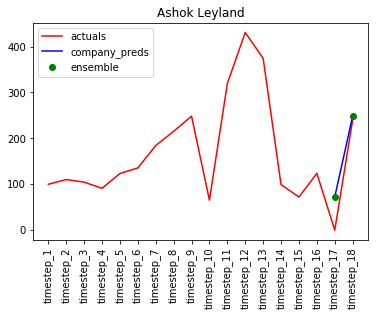

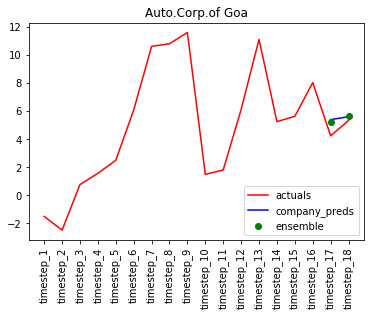

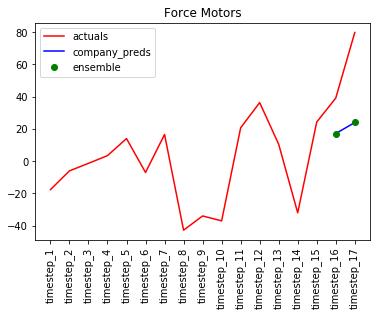

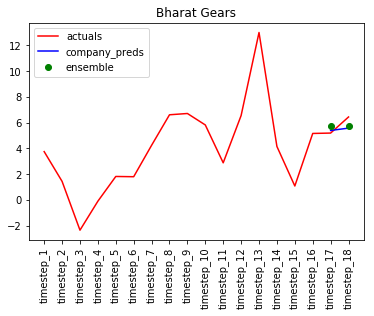

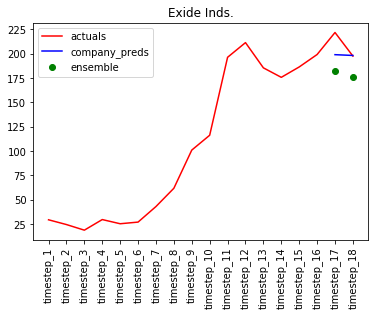

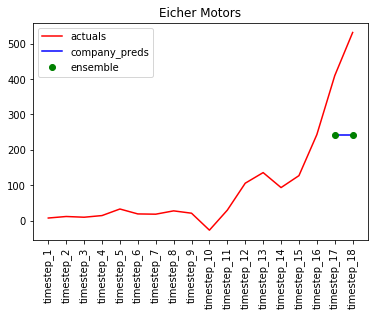

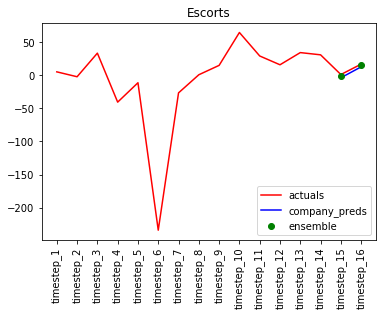

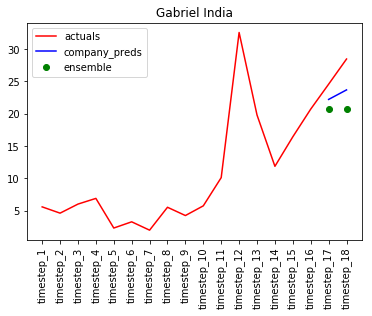

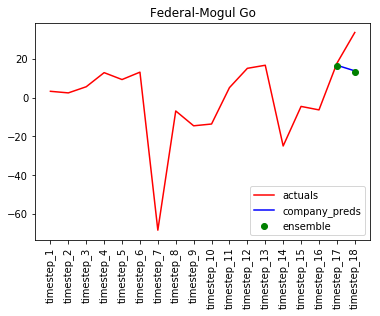

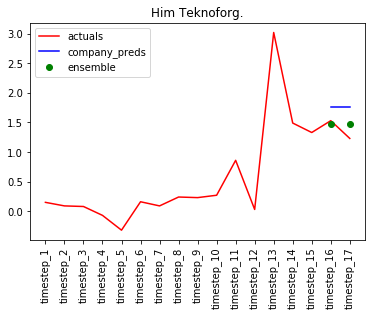

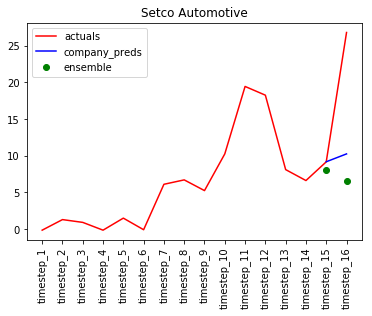

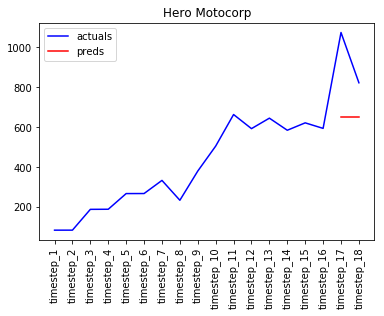

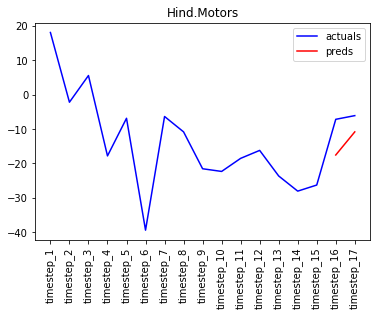

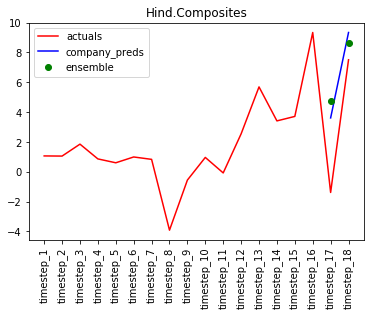

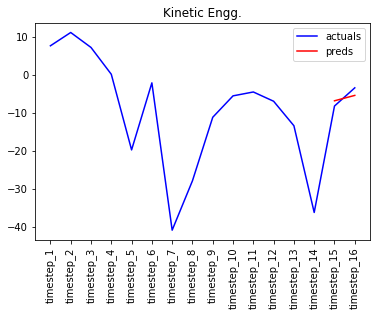

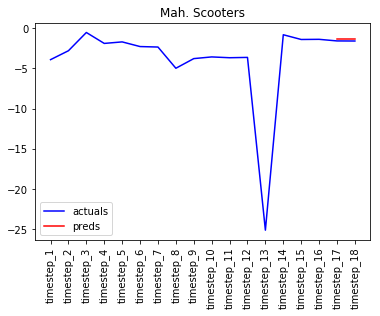

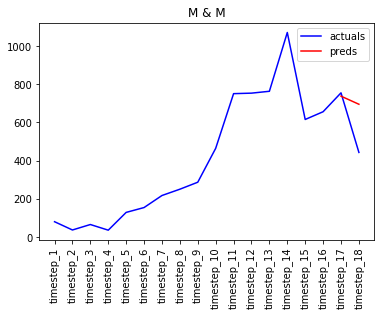

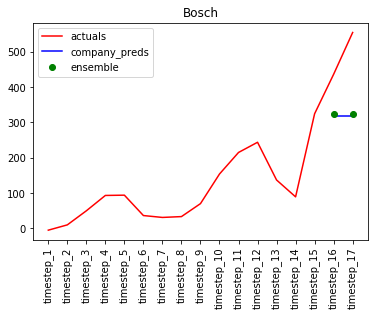

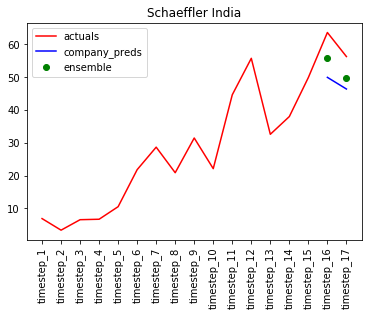

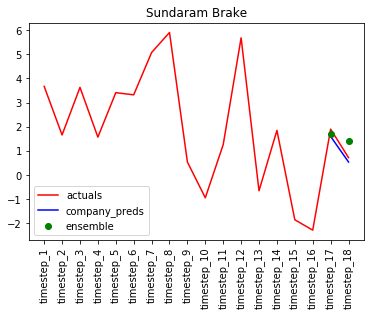

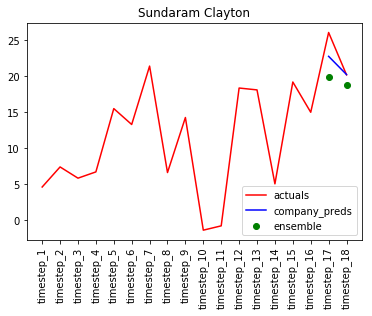

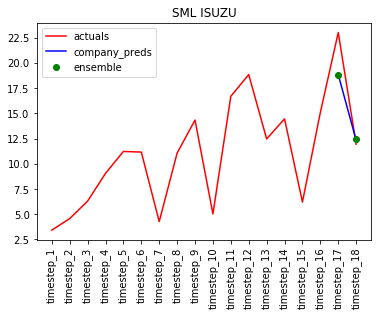

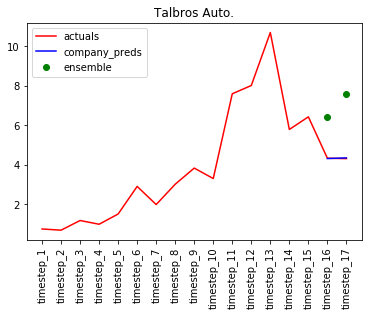

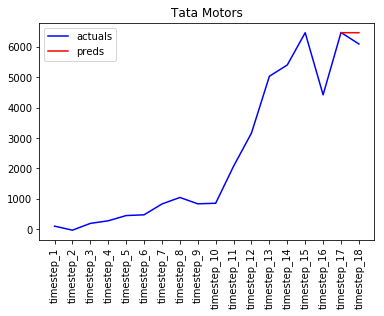

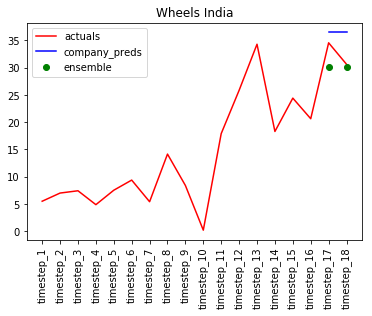

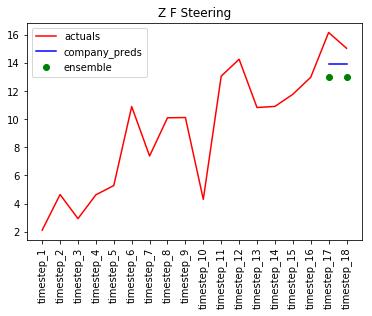

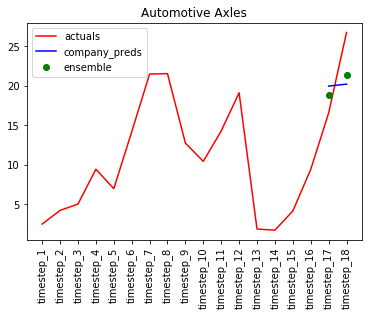

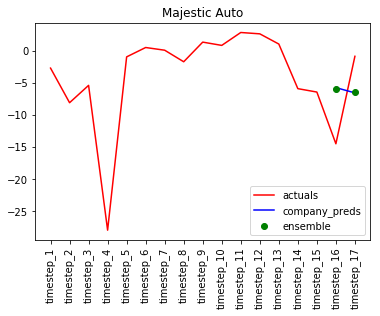

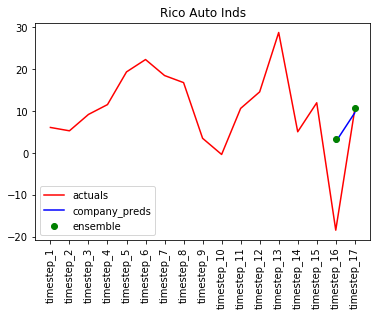

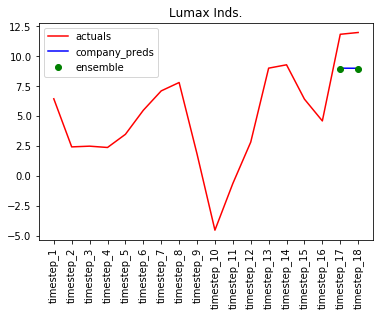

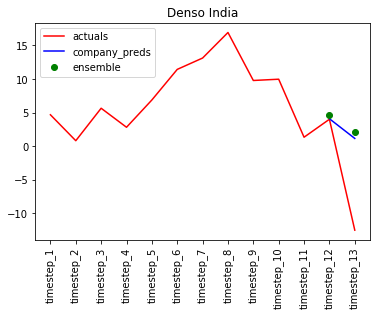

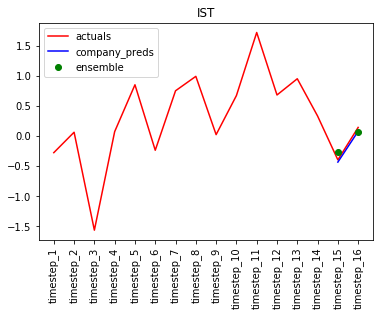

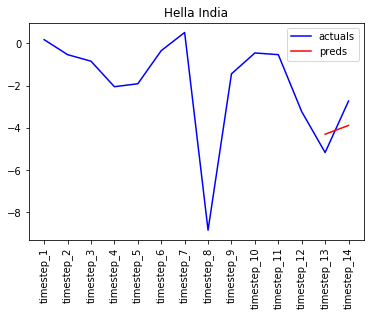

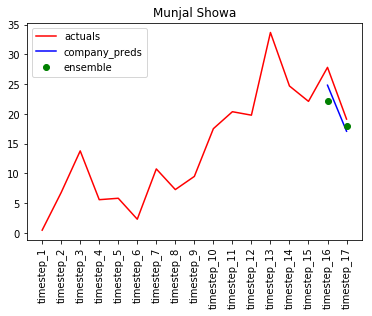

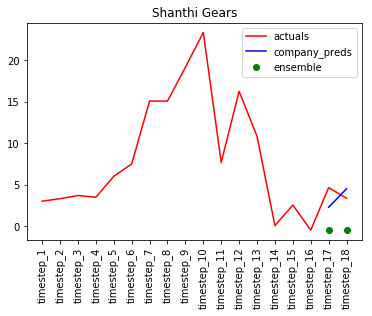

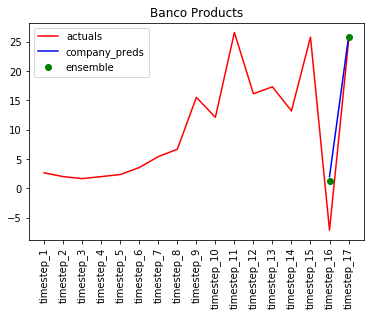

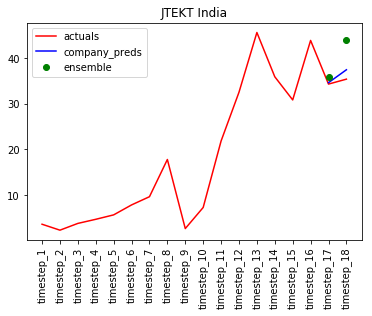

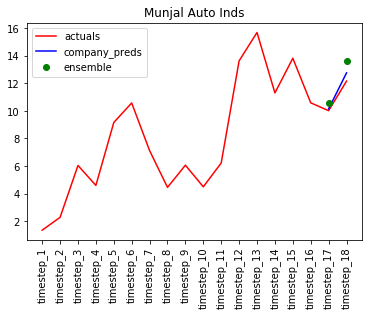

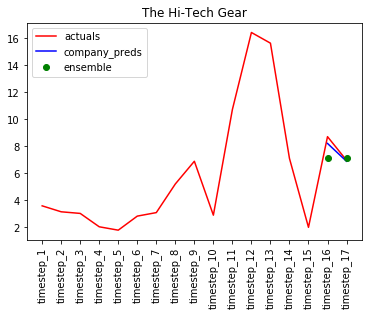

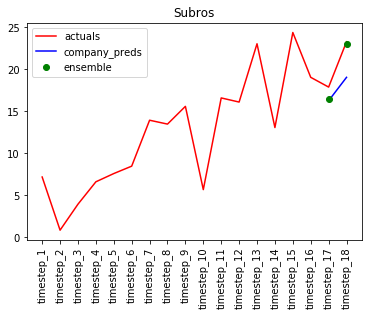

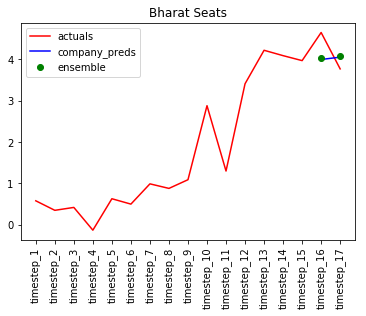

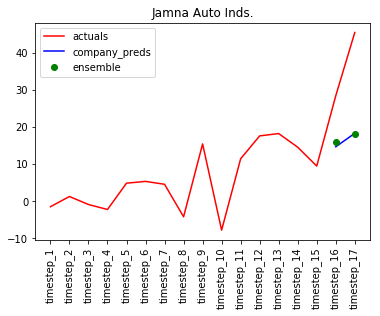

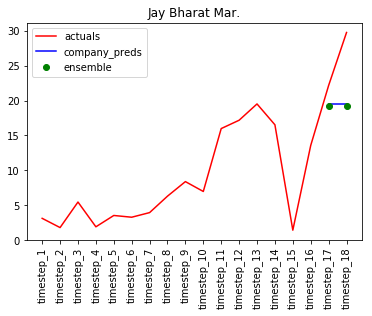

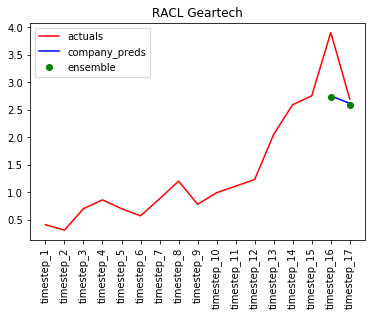

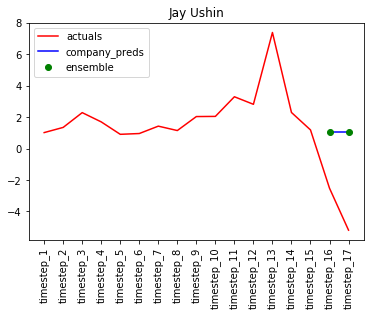

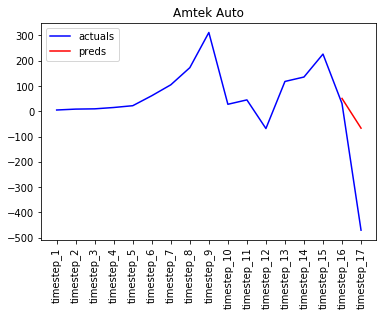

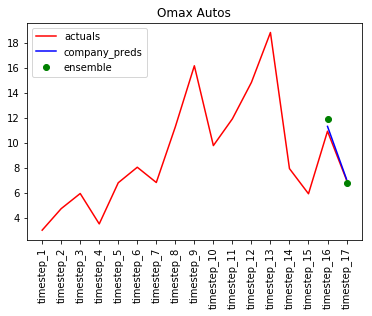

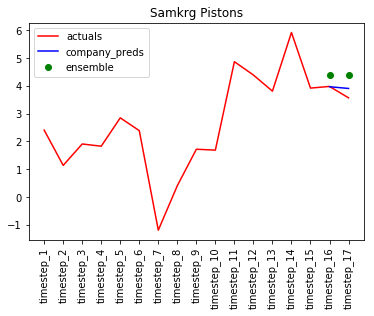

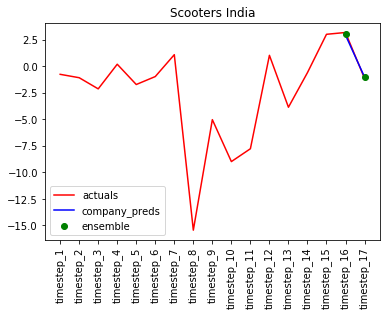

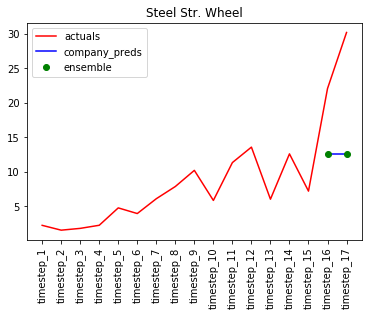

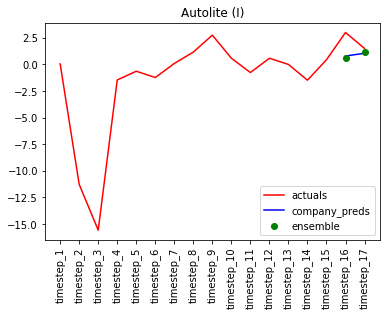

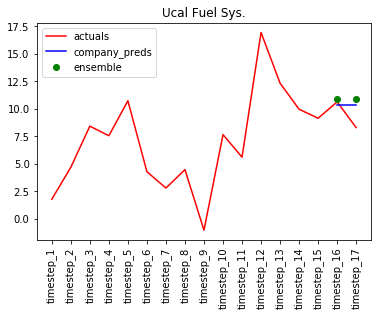

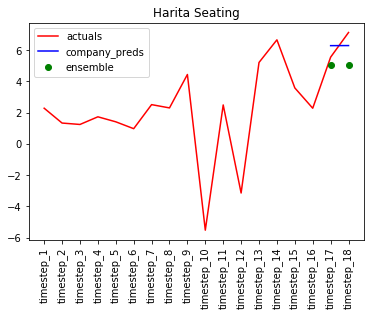

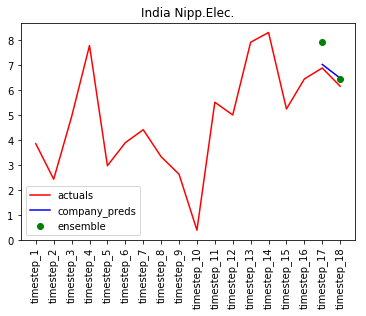

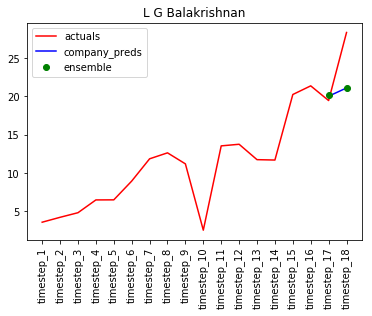

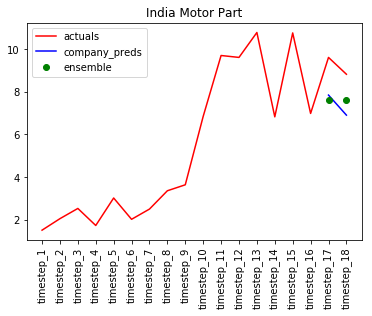

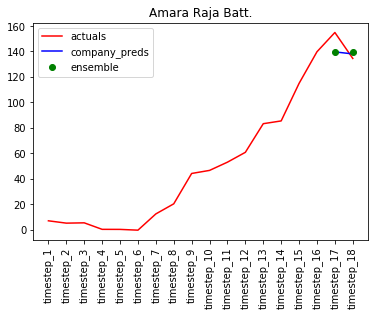

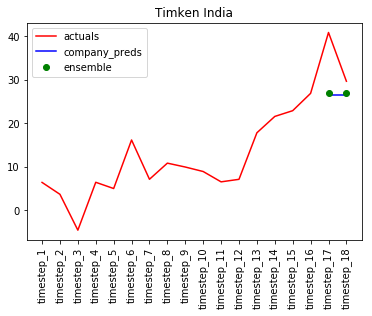

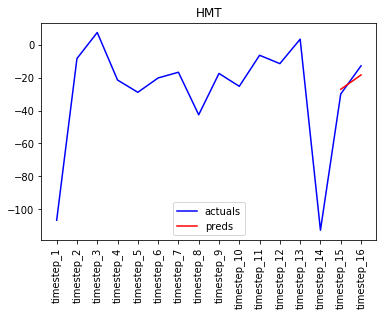

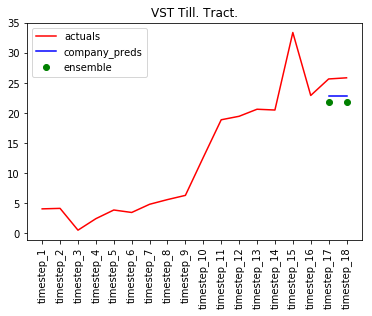

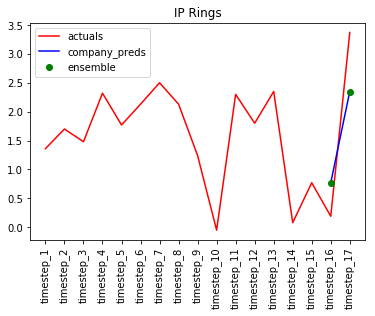

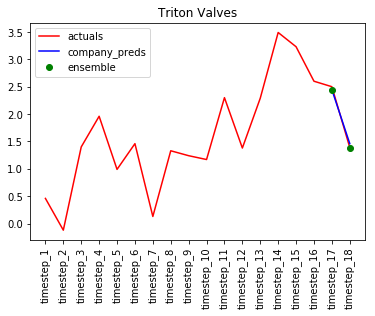

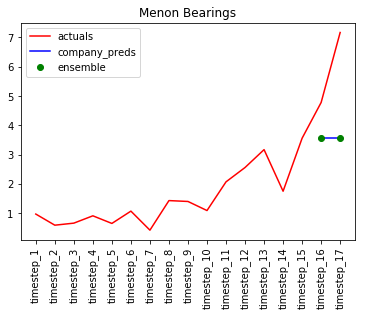

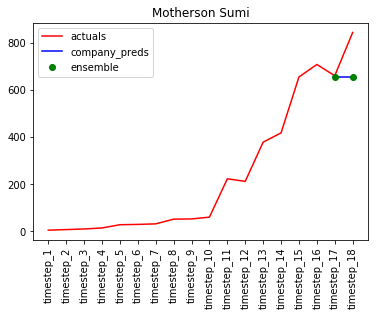

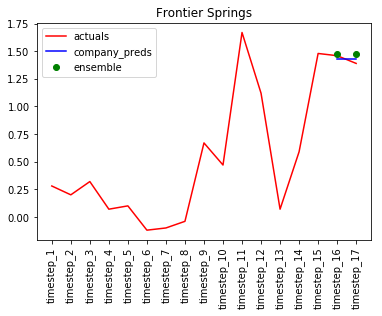

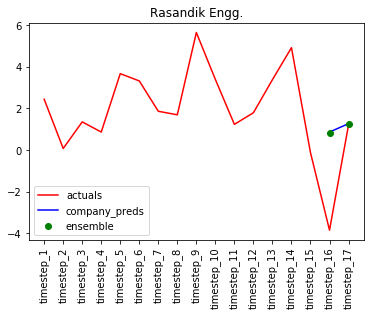

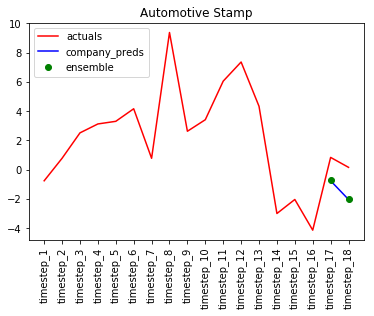

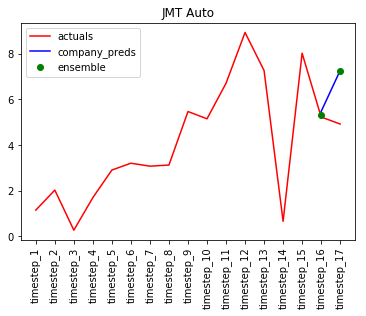

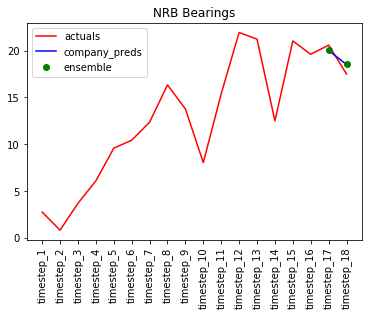

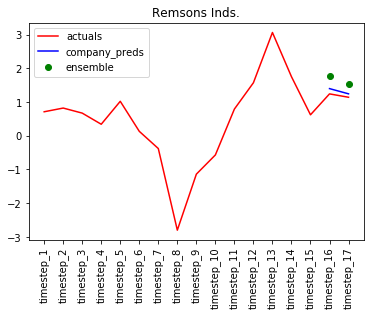

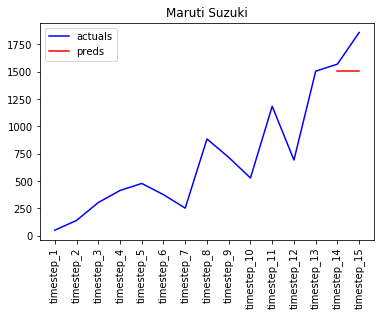

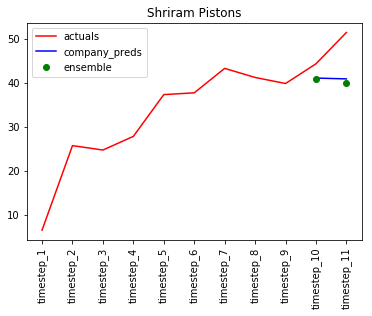

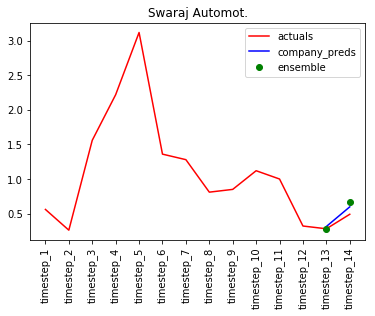

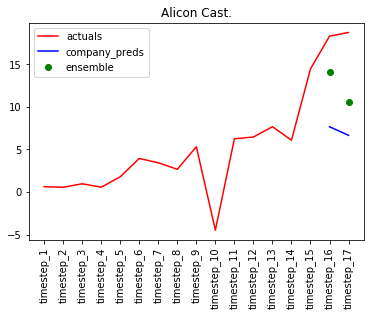

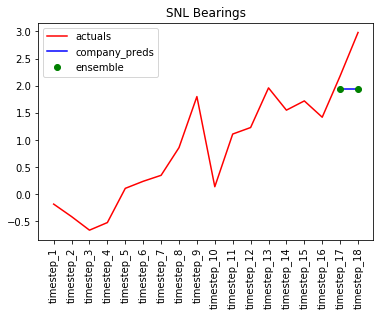

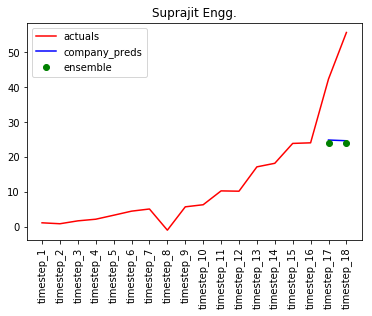

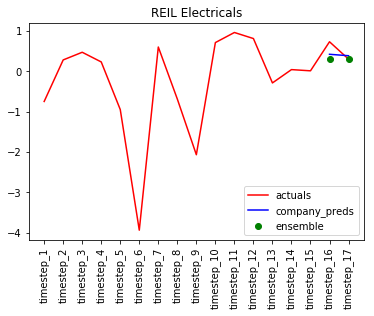

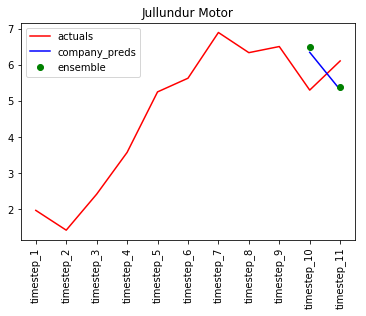

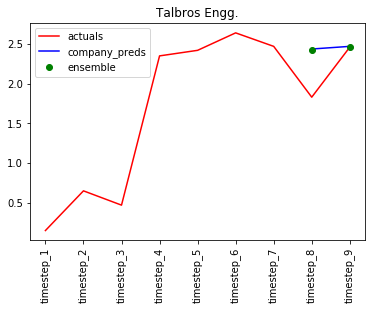

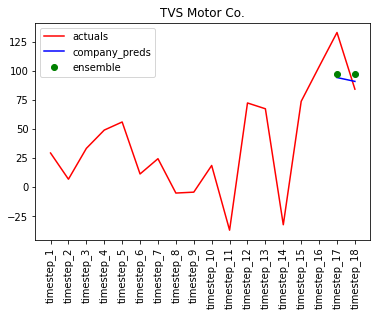

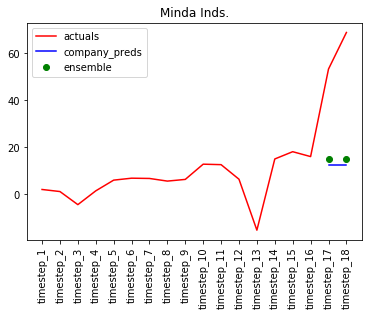

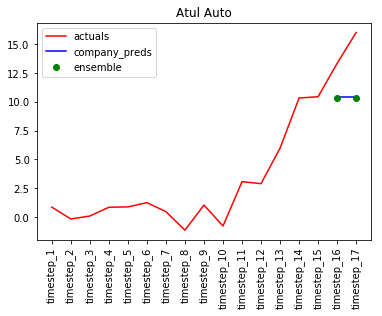

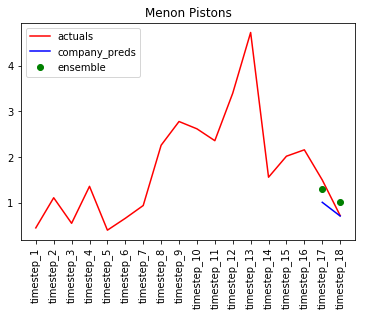

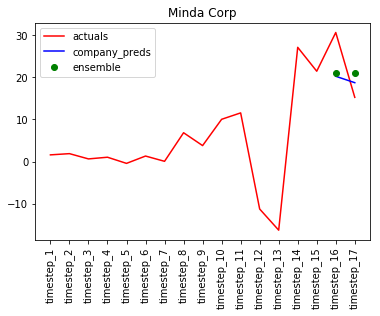

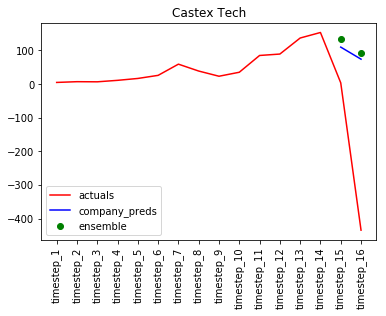

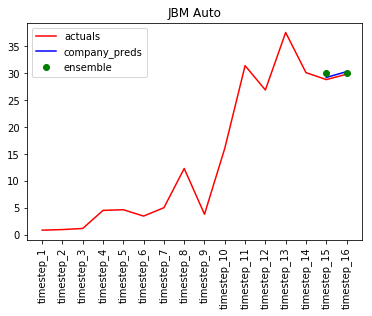

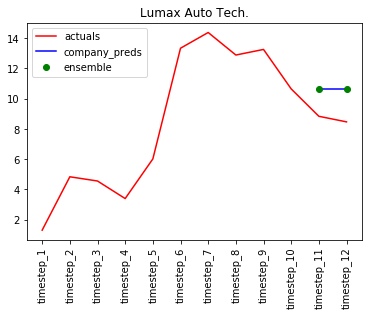

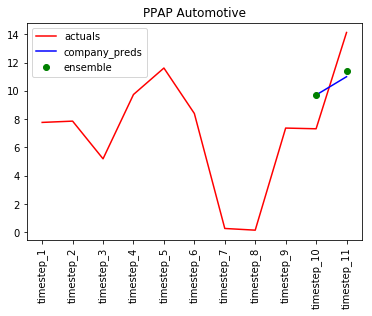

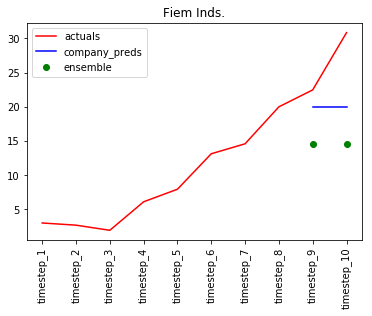

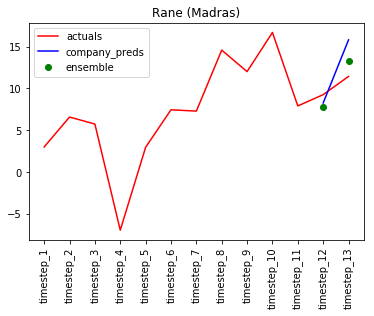

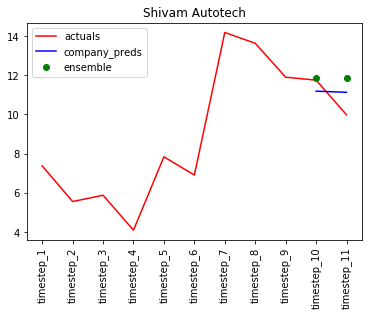

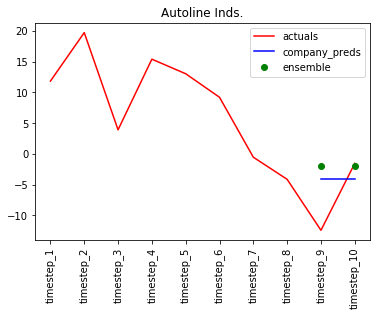

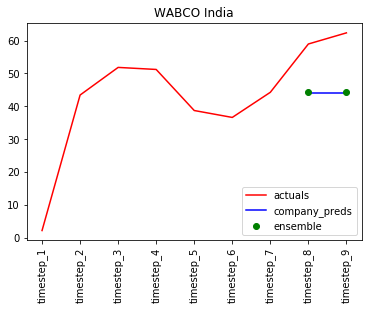

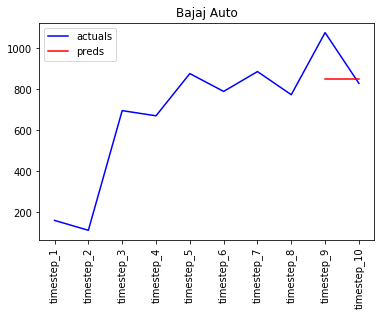

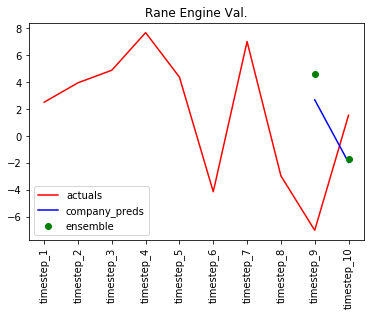

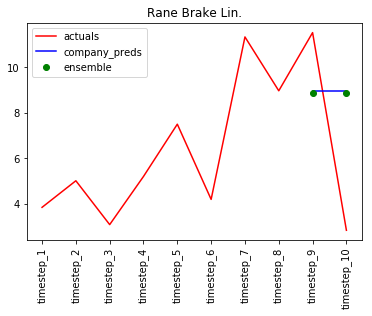

In [459]:
for i in list(cmpy_dict.keys()):
    ensemble_company(i)

In [460]:
l = []
for i in list(cmpy_dict.keys()):
    l.append([i ,return_cluster_name(i)[0] ,ind_test_actuals[i].mean() , mean_absolute_error(ind_test_actuals[i],ind_test_preds[i]) , mean_absolute_error(ind_test_actuals[i],ens_preds_dict[i])])

l = pd.DataFrame(l , columns=['company_name','cluster','Average_Ebit','ind_model_MAE','ens_model_MAE'])

l.to_excel('./reports/ind_model_and_ens_model_with_tune.xlsx',index=False)

In [ ]:
## prepare ind_model and ens_model predictions and MAE
